# GEONE - GEOSCLASSIC - Examples in 2D - non-stationary covariance model

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

See notebook `ex_geosclassic_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS) in a grid.

## Non-stationary covariance model over a grid
See notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb` for detail explanations on how to set non-stationarities in a grid.

## Examples in 2D
In this notebook, examples in 2D with a non-stationary covariance model are given.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Grid (2D)

In [3]:
nx, ny = 220, 230  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (sx, sy)
origin = (ox, oy)

## Covariance model

In 2D, a covariance model is given by an instance of the class `geone.covModel.covModel2D` (or `geone.covModel.covModel1D` for omni-directional (isotropic) case).

### Base covariance model (sationary)
The weight `'w'` to every elementary contribution is set to `1.0`; the method `multiply_w` will be used to set non-stationarities about this parameter; angle `alpha` is set to `0`, local rotation will be set further.

In [4]:
# Define the base covariance model (stationary)
cov_model = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':1.0, 'r':[120.0, 30.0]}), # elementary contribution
    ('gaussian',  {'w':1.0, 'r':[120.0, 30.0]}), # elementary contribution
    ], alpha=0, name='model-2D example')

In [5]:
# cov_model.plot_model(figsize=(15,5))
# plt.suptitle('Covariance function - base')
# plt.show()

### Defining non-stationarities


In [6]:
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Center of the grid
x_center = 0.5*(im.xmin() + im.xmax())
y_center = 0.5*(im.ymin() + im.ymax())

# Set alpha in degrees in the grid for further estimation/simulation
# ------------------------------------------------------------------
t = 180.0/np.pi
alpha = 90.0 - np.arctan2(yy-y_center, xx-x_center)* t - 20.
# Note: `alpha` could also be a function of two parameters (x, y location) 

# Define weight for gaussian model over the simulation grid
gau_w = 9. * 1. / (1. + np.exp(-(np.sqrt((xx-x_center)**2+(yy-y_center)**2)-50)/20))
sph_w = 9. - gau_w

# Set list to handle non-stationarities for further estimation/simulation in the grid
# -----------------------------------------------------------------------------------
cov_model_non_stationarity_list = [
    ('multiply_w', sph_w, {'elem_ind':0}), # multiply weight by `sph_w` for elem. contrib. of index 0
    ('multiply_w', gau_w, {'elem_ind':1}), # multiply weight by `gau_w` for elem. contrib. of index 1
]
# Note: `gau_w`, `nug_w` could also be a function of two parameters (x, y location) 

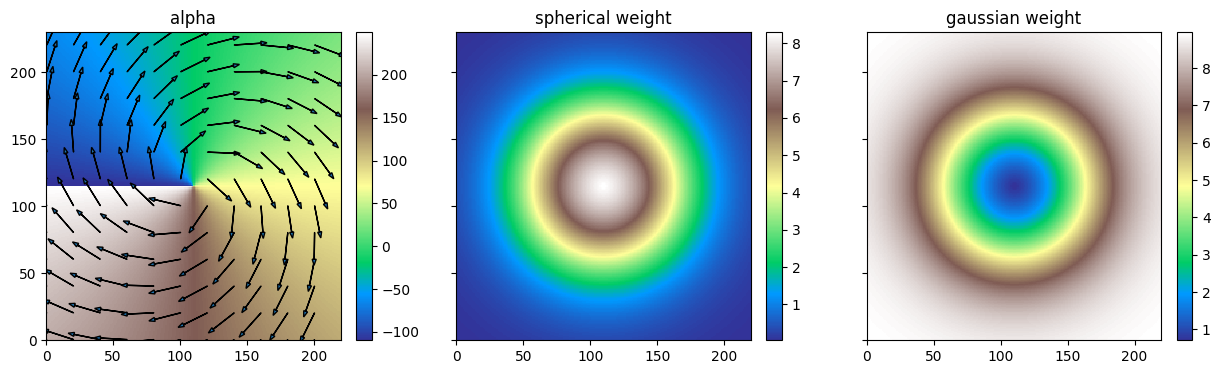

In [7]:
# Plot non-stationarities

# Set variable alpha, sph_w and gau_w in image im
im.append_var([alpha, sph_w, gau_w], varname=['alpha', 'sph_w', 'gau_w'])

# Plot
plt.subplots(1,3, figsize=(15, 4), sharex=True, sharey=True)

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im, iv=0, cmap='terrain', title="alpha")
len_arrow = 20.
for i in range(0, nx, 20):
    for j in range(0, ny, 20):
        u = xx[j, i]
        v = yy[j, i]
        a = -alpha[j,i]/t
        plt.arrow(u, v, len_arrow*np.cos(a), len_arrow*np.sin(a), head_width=3)

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im, iv=1, cmap='terrain', title="spherical weight")

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im, iv=2, cmap='terrain', title="gaussian weight")

plt.show()

## Set-up (for estimation and simulation)

In [8]:
# Data
x = np.array([[ 10.5 ,  20.5 ],  
              [ 50.82,  40.25],  
              [ 20.34, 150.95],  
              [ 97.14, 118.35],  
              [200.52, 210.74]]) # data locations (real coordinates)
v = [ -3., 2., -1., 5., -1.]  # data values
v_err_std = 0.0                  # data error standard deviation
# v_err_std = [0.0, 0.0, 5, 1.0]   # data error standard deviation
                                 #     float: same for all data points
                                 #     list or array: per data point

# Inequality data
x_ineq = np.array([[ 175.5 ,  60.5 ],
                   [ 125.95, 100.82], 
                   [  75.34, 175.35]]) # locations (real coordinates)
v_ineq_min = [  -2.2,    4.0 ,  np.nan]  # lower bounds
v_ineq_max = [  -1.4, np.nan,   -4.1]    # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Type of kriging
method = 'simple_kriging'

# Non-stationarities for covariance model: see `alpha` for local rotation and `cov_model_non_stationarity_list` above

### Estimation (kriging)

In [9]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            alpha=alpha,                   # rotation
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 5, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (3 times in all):
#  1: WARNING 02001: a

### Simulations

In [10]:
# Number of realizations
nreal = 250

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            alpha=alpha,                   # rotation
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 5, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (250 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 124...
_run

### Plot the results

In [11]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


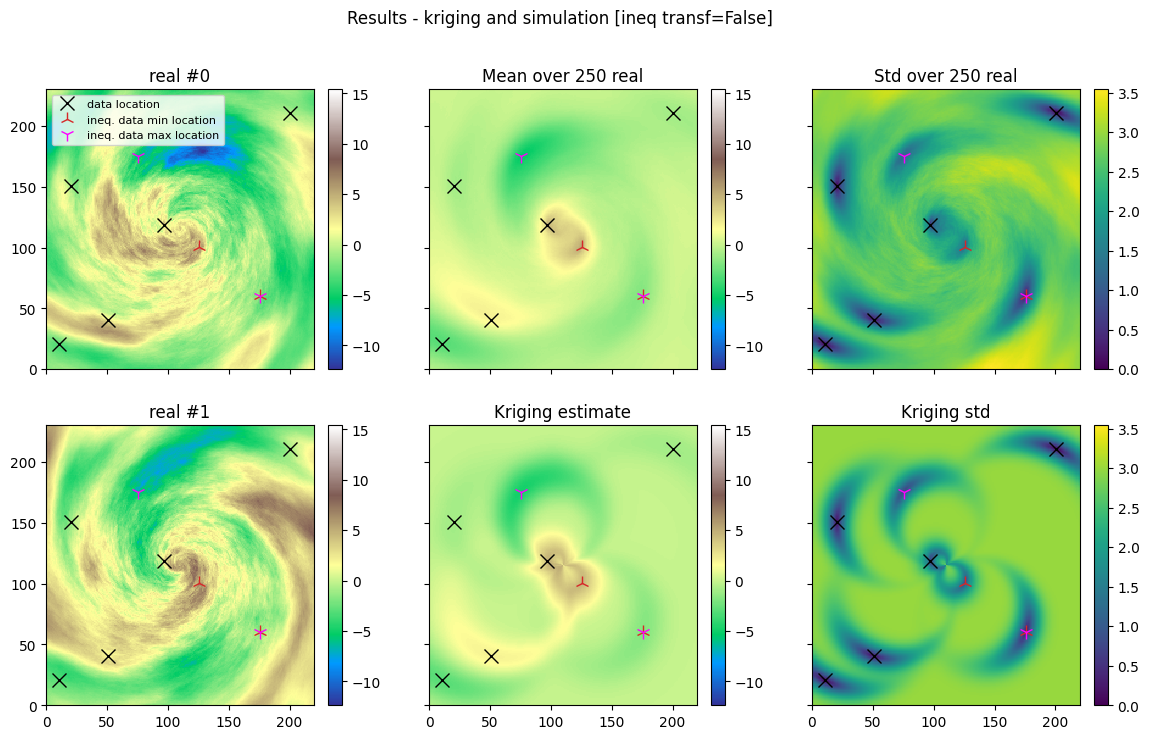

In [12]:
# Plot simulations and kriging results
vmin = simul_img.val.min()
vmax = simul_img.val.max()

std_min = min(simul_img_std.val.min(), krig_img.val[1].min())
std_max = max(simul_img_std.val.max(), krig_img.val[1].max())

cmap = 'terrain'
cmap_std = 'viridis'

def plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max):
    if x is not None:
        # add data
        plt.plot(x[:,0],x[:,1], 'x', c='k', alpha=1.0, markersize=10, label='data location')
    if x_ineq is not None:
         # add inequality data, lower bound
        label = 'ineq. data min location'
        for i, vv in enumerate(v_ineq_min): 
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '2', c='tab:red', alpha=1.0, markersize=10, label=label)
                label = None
        # add inequality data, upper bound
        label = 'ineq. data max location'
        for i, vv in enumerate(v_ineq_max):
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '1', c='magenta', alpha=1.0, markersize=10, label=label)
                label = None

fig, ax = plt.subplots(2, 3, figsize=(14,8), sharex=True, sharey=True)
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(simul_img_mean, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(simul_img_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig_img, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig_img, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging std')

plt.suptitle(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

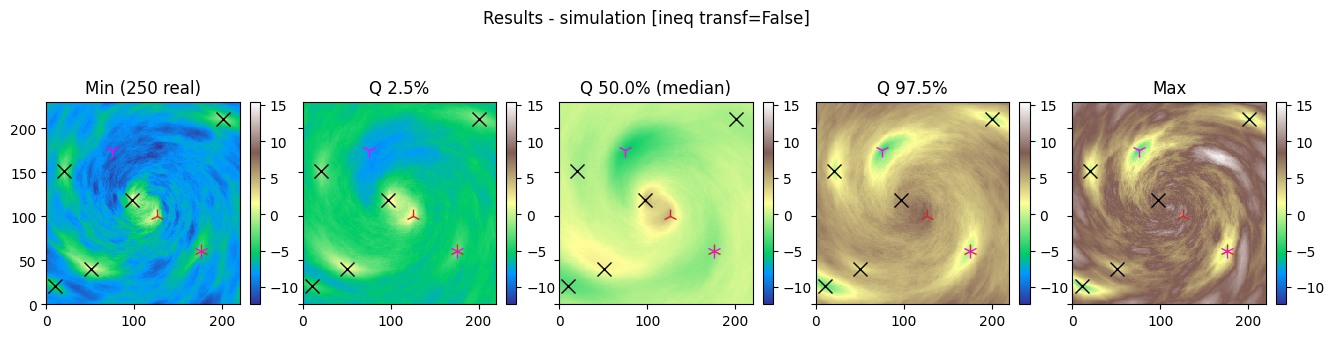

In [13]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Max')

plt.suptitle(f'Results - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [14]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0
   data value                         = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.000e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = -3.000e+00, min = -3.000e+00, max = -3.000e+00 [std = 0.000e+00]
Data point index 1, dist. to cell center = 0.4061
   data value                         = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 2.000e+00 [krig. std = 1.243e-01]
   simul. [ineq transf=False]   : mean = 1.994e+00, min = 1.786e+00, max = 2.249e+00 [std = 8.892e-02]
Data point index 2, dist. to cell center = 0.4776
   data value                         = -1.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -1.000e+00 [krig. std = 1.376e-01]
   simul. [ineq transf=False]   : mean = -1.004e+00, min = -1.234e+00, max = -7.215e-01 [std = 9.768e-02]
Data point index 3, dist. to cell center = 0.39
   data value             

In [15]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 100.000%
Ineq. data point index 1, dist. to cell center = 0.5522
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 86.800%
Ineq. data point index 2, dist. to cell center = 0.2193
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 96.000%
